<a href="https://colab.research.google.com/github/ArleyCeballos/DeepLearningUDEA/blob/main/Notebook_Proyecto_Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
import shutil
import os
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from PIL import Image, ImageOps
from numpy import asarray
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import gdown
import numpy as np
from keras import backend as K
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 16.4 MB/s eta 0:00:00


# Cargar el dataset


In [ ]:
import gdown

# Definir la URL de Google Drive del archivo
file_url = "14QSH1n3VKeLaM7JUhONV8PHOd61xG6PB"

# Especificar el nombre del archivo
file_name = "kaggle.json"

# Descargar el archivo desde Google Drive
!gdown --id {file_url} -O {file_name}

# Mover el archivo a la ubicación específica
!mkdir -p ~/.kaggle/ && mv {file_name} ~/.kaggle/ && chmod 600 ~/.kaggle/{file_name}


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14QSH1n3VKeLaM7JUhONV8PHOd61xG6PB
To: /content/kaggle.json
100% 76.0/76.0 [00:00<00:00, 448kB/s]


**Usar este metodo solo si el anterior no funciono**

In [ ]:
#Download kaggle dataset
!kaggle competitions download -c vehicle

100% 6.88G/6.88G [05:21<00:00, 23.5MB/s]
100% 6.88G/6.88G [05:21<00:00, 23.0MB/s]


In [ ]:
#Unzip kaggle Datset
!unzip vehicle '*/*/Car/*' '*/*/Motorcycle/*' '*/*/Truck/*' '*/*/Bus/*' -d "./dataset" > ./.logs

In [ ]:
import os

# Ruta del directorio donde se extrajo el dataset
ruta_directorio = "/content/"

# Función para calcular el tamaño de un directorio
def obtener_tamano_directorio(ruta):
    total_tamano = 0
    for dirpath, dirnames, filenames in os.walk(ruta):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_tamano += os.path.getsize(fp)
    return total_tamano

# Obtener el tamaño del directorio
tamano_descomprimido = obtener_tamano_directorio(ruta_directorio)

# Convertir el tamaño a GB para mayor claridad
tamano_descomprimido_gb = tamano_descomprimido / (1024**3)

print(f"El tamaño del archivo descomprimido es aproximadamente {tamano_descomprimido_gb:.2f} GB")

El tamaño del archivo descomprimido es aproximadamente 9.99 GB


# Prepocesado de los datos

In [ ]:
classes = ['Bus', 'Car', 'Motorcycle', 'Truck']

In [ ]:
#Showing radom images from each class in dataset
plt.figure(figsize=(12,12))
count = 0
for i, cls in enumerate(classes):
  for j in range(5):
    dir = f'/content/dataset/train/train/{cls}'
    filename = random.choice(os.listdir(dir))
    path = os.path.join(dir, filename)
    img = plt.imread(path)
    count += 1
    plt.subplot(5,5,count)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.xlabel(f'{cls}\n ({img.shape[0]}x{img.shape[1]})')

plt.show()


**Dividir los datos en los de test y validacion**

In [ ]:
#Load and transform images in tensorflow

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
  )

train_generator = datagen.flow_from_directory(
    '/content/dataset/train/train',
    target_size=(224, 224),
    batch_size=64,seed=123,
    subset='training',
    color_mode="rgb",
    class_mode='sparse',
)
valid_generator = datagen.flow_from_directory(
    '/content/dataset/train/train',
    target_size=(224, 224),
    batch_size=64,seed=123,
    subset='validation',
    class_mode='sparse',
    color_mode="rgb",
)




Found 11148 images belonging to 4 classes.
Found 2785 images belonging to 4 classes.


In [ ]:
labels_frec = {i:0 for i in classes}
labels = {cls:i for cls,i in enumerate(classes)}

**Cantida de imagenes por clase**

In [ ]:
for i in train_generator.labels:
  labels_frec[labels[int(i)]] = labels_frec[labels[int(i)]] +1
train_class_frec = labels_frec

In [ ]:
train_classes = [labels[int(i)] for i in train_generator.labels]
np.unique(train_classes, return_counts=True)

(array(['Bus', 'Car', 'Motorcycle', 'Truck'], dtype='<U10'),
 array([1707, 5425, 2389, 1627]))

In [ ]:
for i in valid_generator.labels:
    labels_frec[labels[int(i)]] = labels_frec[labels[int(i)]] +1
labels_frec

{'Bus': 2133, 'Car': 6781, 'Motorcycle': 2986, 'Truck': 2033}

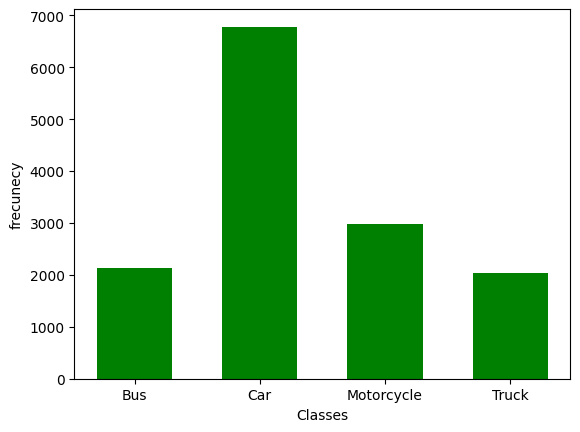

In [ ]:
plt.bar(labels_frec.keys(), labels_frec.values(), color ='green',width = 0.6)
plt.xlabel("Classes")
plt.ylabel("frecunecy")
plt.show()

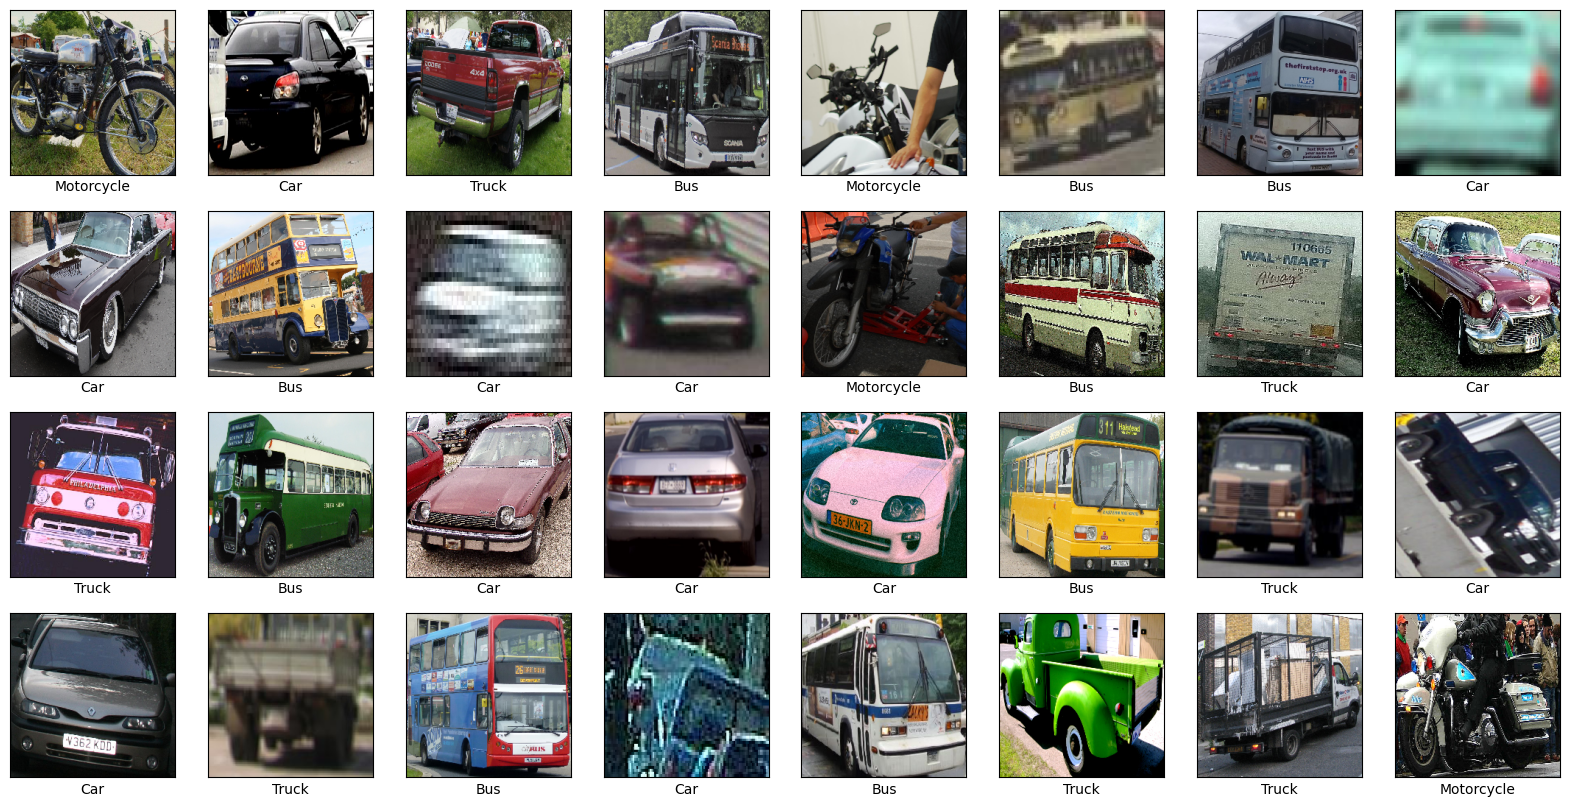

In [ ]:
#showing images after transformations

import numpy as np
fig = plt.figure(figsize=(20,10))
imgs,lbls = train_generator.next()
for i in range(0,32):
  plt.subplot(4,8,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imgs[i].reshape((224,224, 3)), cmap='gray')
  plt.xlabel(classes[int(lbls[i])])
plt.show()

In [ ]:
#Compute Class weights
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced', classes=[0,1,2,3], y=valid_generator.labels.astype(int))
class_weight = dict(zip(range(len(class_weight)), class_weight))
class_weight

{0: 1.6343896713615023,
 1: 0.5134587020648967,
 2: 1.166247906197655,
 3: 1.7149014778325122}

**Se definen las metricas**

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# from sklearn.metrics import multilabel_confusion_matrix
def conf_matrix_m(y_true, y_pred):
  return tf.math.confusion_matrix(y_true, K.argmax(y_pred), num_classes=4)

#Modelo CNN

**Se crea el modelo CNN**

In [ ]:

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(224, 224, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.5)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

# model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer="Nadam",
              metrics=['accuracy', f1_m, conf_matrix_m, precision_m, recall_m ]
              )



**Se entrena el modelo**

In [ ]:
history =model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    validation_data=valid_generator,
                    validation_steps = len(valid_generator),
                    class_weight=class_weight,
                  )

Epoch 1/20
175/175 [==============================] - 240s 1s/step - loss: 2.6718 - accuracy: 0.4851 - f1_m: 1.0640 - conf_matrix_m: 3.9814 - precision_m: 1.0373 - recall_m: 1.0967 - val_loss: 4.9712 - val_accuracy: 0.2323 - val_f1_m: 1.1510 - val_conf_matrix_m: 3.9560 - val_precision_m: 1.1070 - val_recall_m: 1.2011
Epoch 2/20
 84/175 [=============>................] - ETA: 1:26 - loss: 0.9438 - accuracy: 0.6124 - f1_m: 1.1176 - conf_matrix_m: 4.0000 - precision_m: 1.1550 - recall_m: 1.0860

**Se guarda el modelo(en .h5 y json)**

In [ ]:
model.save('my-model.h5',)

In [ ]:
model.save('my-model-h5', save_format='h5')

In [ ]:
model.to_json()

**Se crea la matrix de confusion**

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

y_pred = []
y_true = []
valid_generator.reset()
for i in range(88):
  x,y = valid_generator.next()
  y_true += y.astype(int).tolist()
  y_pred += list(np.argmax(model.predict(x), axis=1))

In [ ]:
cm = tf.math.confusion_matrix(y_true, y_pred)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm)
df_cm= df_cm.astype(int)
# df_cm = df_cm.reindex(classes)
df_cm.index = classes
df_cm.columns = classes
df_cm

sn.heatmap(df_cm, annot=True, fmt='d',)
plt.ylabel('true class')
plt.xlabel('predicted class')
plt.show()

In [ ]:
np.unique(valid_generator.labels, return_counts=True)

In [ ]:
!pip3 install visualkeras

**Arquitectura del modelo**

In [ ]:
#Visualize model architecture
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(model, legend=True, to_file='model-image.png')

**Accuracy del modelo a lo largo de las epocas**

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

**Loss del modelo a lo largo de las epocas**

In [ ]:
#showing loss over epochs

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
# prediction= model.predict(valid_generator,batch_size=32, verbose=1)

In [ ]:
eval = model.evaluate(valid_generator)
eval

In [ ]:
eval

**Prueba del modelo usando imagenes de validacion**

In [ ]:
x = valid_generator.next()

offset = 5
fig = plt.figure(figsize=(25,10))
for i in range(8):
  plt.subplot(1,8,i+1)
  img = valid_generator[0][0][i+offset]
  plt.imshow(img.reshape(224,224,3))
  img = np.expand_dims(img, axis=0)
  pred = model.predict(img)[0]
  plt.xticks([])
  plt.yticks([])
  plt.title(classes[int(valid_generator[0][1][i+offset])])

fig = plt.figure(figsize=(25,4))
for i in range(8):
  plt.subplot(1,8,i+1)
  img = valid_generator[0][0][i+offset]
  img = np.expand_dims(img, axis=0)
  pred = model.predict(img)[0]
  prob = {i:j for i,j in zip(classes,list(pred))}
  plt.bar(prob.keys(), prob.values())
  plt.xticks(rotation='vertical')


In [ ]:
from PIL import Image, ImageOps
from numpy import asarray

In [ ]:
valid_generator.next()[0].shape

#Segundo Modelo CNN 2


**Se crea el segundo modelo CNN**

In [ ]:
from tensorflow.keras import layers, models

# New CNN model
model2 = models.Sequential()

# Input Layer
model2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layers
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.3))

model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.3))

# Fully-Connected Layer
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(4, activation='softmax'))

# Compile the model
model2.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy', f1_m, conf_matrix_m, precision_m, recall_m])


**Se entrena el modelo**

In [ ]:
#Train the model
history =model2.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    validation_data=valid_generator,
                    validation_steps = len(valid_generator),
                    class_weight=class_weight,
                  )

**Se guarda el modelo**

In [ ]:
model2.save('my-model2.h5',)

In [ ]:
model2.save('my-model2-h5', save_format='h5')

In [ ]:
model2.to_json()

**Se visualiza la arquitectura**

In [ ]:
#Visualize model2 architecture
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(model2, legend=True, to_file='model2-image.png')

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

y_pred = []
y_true = []
valid_generator.reset()
for i in range(88):
  x,y = valid_generator.next()
  y_true += y.astype(int).tolist()
  y_pred += list(np.argmax(model2.predict(x), axis=1))

In [ ]:
cm = tf.math.confusion_matrix(y_true, y_pred)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm)
df_cm= df_cm.astype(int)
# df_cm = df_cm.reindex(classes)
df_cm.index = classes
df_cm.columns = classes
df_cm

sn.heatmap(df_cm, annot=True, fmt='d',)
plt.ylabel('true class')
plt.xlabel('predicted class')
plt.show()

**Accuracy del modelo a lo largo de las epocas**

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

**loss del modelo a lo largo de las epocas**

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
eval = model2.evaluate(valid_generator)
eval

**Se evalua el modelo usando imagenes de validacion**

In [ ]:
#Show some images and its prediction
x = valid_generator.next()

offset = 5
fig = plt.figure(figsize=(25,10))
for i in range(8):
  plt.subplot(1,8,i+1)
  img = valid_generator[0][0][i+offset]
  plt.imshow(img.reshape(224,224,3))
  img = np.expand_dims(img, axis=0)
  pred = model2.predict(img)[0]
  plt.xticks([])
  plt.yticks([])
  plt.title(classes[int(valid_generator[0][1][i+offset])])

fig = plt.figure(figsize=(25,4))
for i in range(8):
  plt.subplot(1,8,i+1)
  img = valid_generator[0][0][i+offset]
  img = np.expand_dims(img, axis=0)
  pred = model2.predict(img)[0]
  prob = {i:j for i,j in zip(classes,list(pred))}
  plt.bar(prob.keys(), prob.values())
  plt.xticks(rotation='vertical')

#Transfer learning with pretrained VGG16 model

**Se usa el VGG16 para probar como funciona y ver como se desempeña en comparacion con los modelos propios**

In [ ]:
image_input = Input(shape=(224, 224, 3))

model2 = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')


last_layer = model2.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(len(classes), activation='softmax', name='output')(x)
custom_model = Model(image_input, out)

# freeze all the layers except the dense layers
for layer in custom_model.layers[:-3]:
	layer.trainable = False

custom_model.summary()

custom_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adadelta',
    metrics=['accuracy', f1_m, conf_matrix_m, precision_m, recall_m ]
)

In [ ]:
vgg16_history = custom_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=valid_generator,
    validation_steps = len(valid_generator),
    class_weight=class_weight,
)

In [ ]:
custom_model.save('my-vgg16-model.h5',)
!zip -r my-vgg16-model.zip my-vgg16-model.h5

In [ ]:
custom_model.save('my-model-h5', save_format='h5')

In [ ]:
custom_model.to_json()

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

y_pred = []
y_true = []
valid_generator.reset()
for i in range(88):
  x,y = valid_generator.next()
  y_true += y.astype(int).tolist()
  y_pred += list(np.argmax(custom_model.predict(x), axis=1))

In [ ]:
vgg16_cm = tf.math.confusion_matrix(y_true, y_pred)

In [ ]:
#Confusion matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(vgg16_cm)
df_cm= df_cm.astype(int)
# df_cm = df_cm.reindex(classes)
df_cm.index = classes
df_cm.columns = classes
df_cm

sn.heatmap(df_cm, annot=True, fmt='d',)
plt.ylabel('true class')
plt.xlabel('predicted class')
plt.show()

In [ ]:
!pip3 install visualkeras

In [ ]:
#Visualize model architecture
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(custom_model, legend=True, to_file='model-image.png')

In [ ]:
#showing accuracy over epochs

import matplotlib.pyplot as plt
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
#showing loss over epochs

plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
eval = custom_model.evaluate(valid_generator)
eval

In [ ]:
#x = valid_generator.next()
valid_generator.next()
valid_generator.next()

offset = 0
fig = plt.figure(figsize=(25,10))
for i in range(8):
  plt.subplot(1,8,i+1)
  img = valid_generator[0][0][i+offset]
  plt.imshow(img.reshape(224,224,3))
  img = np.expand_dims(img, axis=0)
  pred = custom_model.predict(img)[0]
  plt.xticks([])
  plt.yticks([])
  plt.title(classes[int(valid_generator[0][1][i+offset])])

fig = plt.figure(figsize=(25,4))
for i in range(8):
  plt.subplot(1,8,i+1)
  img = valid_generator[0][0][i+offset]
  img = np.expand_dims(img, axis=0)
  pred = custom_model.predict(img)[0]
  prob = {i:j for i,j in zip(classes,list(pred))}
  plt.bar(prob.keys(), prob.values())
  plt.xticks(rotation='vertical')
